In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import scipy.stats


# from src.material_model import LinearElasticity as LE
# from src.sampler import MetropolisHastings, AdaptiveMetropolisHastings

# from ipynb.fs.full.functions import (
#     random_draw,
#     linear_regression,
#     add_labels,
#     plot_posterior,
#     plot_regression_results,
# )

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

# save_figures = False

# Linear Elasticity

This example can be found in Section 5.2 in the following paper: [A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://doi.org/10.1007/s11831-018-09311-x)

## 1. Problem statement

Given a series of experimental observations, obtained from a material specimen undergoing uniaxial tension - for example, stress-strain data - and acknowledging that the observations will be contaminated by a small amount of noise, infer the model parameters that describe the material response with a quantified level of uncertainty.

<span style="color: blue;">
    
We are given a series of experimental observations in the form of stress-strain ($\sigma$-$\epsilon$) data, obtained from a uniaxial tensile test of a linear-elastic material specimen. All observations are contaminated by a degree of noise, and it is essential to acknowledge and mitigate this noise to ensure the accuracy of any subsequent analyses or conclusions drawn from the data. 

</span>

![](figures/linear-elastic-experimental-observations.png)

<span style="color: blue;">

#### General problem statement

Given a set of observed realisations of a random variable $X$,

$$S = \{x_1, x_2, ..., x_N\}, \quad x_j \in \mathbb{R}^n$$
 
we aim to infer the underlying probability distributions that generate the data set $S$.

</span>

## 2. Material model

An expert, upon examining the above experimental observations, could reasonably assume that the material response is best described by a linear elastic model.

In [7]:
class LinearElastic:
    
    def __init__(self, E):
        """
        Parameters
        ----------
        E : float
            Young's Modulus
        """
        self.E = E

    def compute_stress(self, strain):
        """
        Compute stress

        Parameters
        ----------
        strain : float

        Returns
        -------
        stress : float
        """
        return self.E * strain

## 3. Model fitting and inverse problems

The problem statement is an example of an **inverse problem**. The goal of an inverse problem is to estimate an unknown parameter that is not directly observable by using measured data and a mathematical model linking the observed and the unknown.

Central to this process is **model fitting**, where a mathematical model is selected or designed to describe the relationship between observed data and the unknown parameter. This model is adjusted to minimise the disparity between predicted values and actual observations, typically employing optimisation techniques to find the best-fitting parameters. Through model fitting, predictions or estimations about the unknown parameter can be derived.

#### Conventional methods

Linear regression or optimisation techniques are typically employed to address inverse problems. Let us consider a scenario where we have a dataset comprising observed data points and a mathematical model that links these observations to the unknown parameter we aim to estimate. Linear regression, for instance, seeks to establish a linear relationship between the observed data and the unknown parameter. This involves minimising the squared differences between the observed data points and the corresponding predictions made by the model.

However, traditional methods like linear regression have certain limitations when dealing with inverse problems:

1. **Assumptions about linearity:** Linear regression assumes that the relationship between the observed data and the unknown parameter is linear. In many real-world scenarios, this assumption may not hold true, leading to biased estimates.

2. **Overfitting:** Conventional methods may overfit the data, particularly when dealing with high-dimensional datasets or when the model is overly complex relative to the available data. Overfitting can result in poor generalisation performance and unreliable estimates of the unknown parameter.

3. **Uncertainty quantification:** Linear regression typically does not provide a straightforward means to quantify uncertainty in the estimated parameters. It offers **point estimates** without adequately capturing the inherent uncertainty in the data or the model assumptions.

#### Bayesian inference

A Bayesian framework offers significant advantages. In Bayesian inference, we treat the unknown parameter as a random variable and specify a prior distribution representing our initial beliefs or knowledge about the parameter before observing the data. By combining this prior distribution with the likelihood function (which describes how the data are generated given the parameter values) and applying Bayes' theorem, we can derive the posterior distribution, reflecting our updated beliefs about the parameter after observing the data.

There are multiple reasons why a Bayesian framework is better suited for solving inverse problems:

1. **Incorporating prior knowledge:** Bayesian inference enables us to incorporate prior knowledge or beliefs about the unknown parameter into the estimation process. This proves particularly useful when dealing with limited data, as it helps regularise the estimation and reduces the risk of overfitting.

2. **Flexibility in modelling:** Unlike traditional methods, which often rely on specific assumptions about the data-generating process (e.g. linearity in linear regression), Bayesian inference provides a flexible framework for modelling complex relationships and incorporating various sources of uncertainty.

3. **Uncertainty quantification:** Bayesian inference naturally provides a means to quantify uncertainty in the estimated parameters through the posterior distribution. This allows for more informed decision-making by accounting for the inherent uncertainty in the data and the model.

Overall, the Bayesian framework offers a principled approach to solving inverse problems by integrating prior knowledge, capturing uncertainty, and providing more robust and interpretable estimates compared to traditional methods like linear regression.

## 4. Generating synthetic data

In order to introduce the Bayesian approach in the most intuitive manner, the experimental observations are generated numerically so that they deviate from the *true* constitutive model using a known noise model. This allows for a one-to-one comparison between the *true* parameter values and the inferred parameter distributions.

The noise $\Omega$ in the stress measurements has a normal distribution with a zero mean and a standard deviation of $s_{noise}$. Note that in this case, only the stress measurement is contaminated by noise. 

$$\Omega = \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(0, 0.01^2)$$

In [3]:
def generate_synthetic_data(model, x, noise_std_dev, n_observations, seed=None):
    np.random.seed(seed)
    x = np.random.choice(x, n_observations)
    y = model.compute_stress(x)
    noise = np.random.normal(loc=0, scale=noise_std_dev, size=len(y))
    return x, y + noise

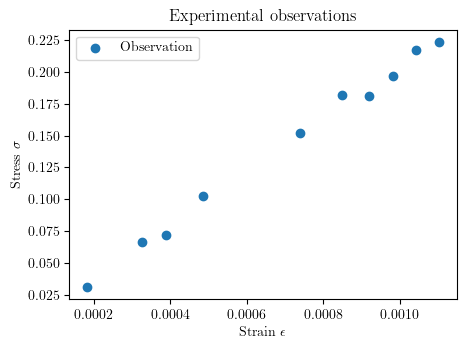

In [4]:
linear = LinearElastic(210)
x = np.linspace(0, 1.2e-3, 100)
strain, stress = generate_synthetic_data(linear, x, 0.01, 10)


plt.figure(figsize=(5, 3.5))
plt.scatter(strain, stress, label='Observation')
plt.title("Experimental observations")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend()
# plt.savefig("figures/linear-elastic-experimental-observations.png", dpi=300)

## Constitutive model and *true* material parameters

It is assumed that the behaviour of the material specimen can be described by a linear elastic law that is defined by a single parameter: Young's modulus $E$. The stress-strain response of the linear elastic model during uniaxial tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon$$

where $\sigma$ denotes the stress, $\epsilon$ the strain, $\textbf{x}$ the model parameter vector (here $\textbf{x} = E$) and $E$ the Young's modulus. The *true* value of $E$ that we are attempting to identify (infer) from the experimental observations is:

$$E = 210 \; \textrm{GPa}$$

The *true* stress-strain response and the noisy experimental observations are illustrated in the following figure.

In [5]:
def material_model(E, epsilon):
    """
    Linear-elastic material model - calculate
    stress as a function of strain
    """
    return E * epsilon

In [6]:
model.stress_strain_response(strain)
plt.scatter(strain_data, stress_data);

NameError: name 'model' is not defined

## Bayesian inference

We have some noisy experimental data from a uniaxial tensile test of a material specimen. Using our expert judgement we have hypothesised that the material response can be described by a linear-elastic material law. We now wish to identify (infer) the model parameters from the experimental observations. 

The most commonly used approach to identify model parameters is to formulate an error function that measures the difference between the model response and the experimental data. The error function is then minimised with respect to the model parameters in order to determine the most suitable values (linear regression etc). This approach provides a deterministic estimate of model parameters, and is unable to account for the unavoidable uncertainties associated with determining parameters from noisy experimental data.

The Bayesian approach enables a rigorous treatment of all sources of uncertainy, for example, noise in the experimental observations and model uncertainty (uncertainty due to assumptions and simpliciations made in the physical model). The model and model parameters that explain an observed data set are treated as uncertain variables, as opposed to deterministic variables. Bayesian inference provides a framework to learn the entire distribution of model parameters, not just deterministic estimates, which maximize the probability of observing the given data. Learning comes from two sources: (1) the evidence provided by the observed data, and (2) domain knowledge from experts (i.e. prior knowledge).

## Bayes' theorem

Baye's theorem is used to determine the probability of a hypothesis given observed evidence (the posterior probability). In this example, we can think of the hypothesis and evidence as follows:

- **Hypothesis:** we hypothesise a value for the model parameters and then we assess how well the model parameters explain the observations
- **Evidence:** the evidence is in the form of experimental observations (stress-strain data from a uniaxial tensile test)

The posterior probability is a function of the prior probability (prior knowledge) and a "likelihood function" derived from a statistical model for the observed data. Bayesian inference computes the posterior probability according to Bayes' theorem:

$$\pi(\textbf{x}|\textbf{y}) = \frac{\pi(\textbf{x})\pi(\textbf{y}|\textbf{x})}{\pi(\textbf{y})}$$

where $\pi(\textbf{x}|\textbf{y})$ is the posterior probability, $\pi(\textbf{x})$ is the prior probability, $\pi(\textbf{y}|\textbf{x})$ is the likelihood and $\textbf{x}$ denotes a vector with $n_p$ model parameters and $\textbf{y}$ denotes a vector with $n_m$ observations.

## Prior $\pi(\textbf{x})$

The prior contains one's prior belief about the value of a parameter before evidence is taken into account. We can obtain a prior from the assessment of an expert or by consulting the literature (e.g. typical values of material stiffness $E$).

The only unknown parameter is the material stiffness $E$ and we use a prior in the form of a modified normal distribution:

$$\pi(E) \propto exp\left(-\frac{(E - \overline{E})^2}{2s^2_E}\right) \quad \text{if}\; E \geqslant 0$$

In [ ]:
def prior_distribution(x, mean, std_dev):
    return np.exp(-((x - mean) ** 2 / (2 * std_dev**2)))

In [ ]:
def set_prior(pi, mean, std_dev):
    def wrapper(x):
        return pi(x, mean, std_dev)

    return wrapper

## Likelihood $\pi(\textbf{y}|\textbf{x})$

The likelihood function represents the probability that the observed data $\textbf{y}$ was generated by the model parameters $\textbf{x}$. Thus, when evaluated on a given sample of the model parameters $\textbf{x}$, the likelihood function indicates which parameter values are more likely than others, in the sense that they would have made the observed data $\textbf{y}$ more probable. A low value of likelihood would indicate that either the data is rare or the model/model parameters are wrong. To construct the likelihood function we need to define a model that represents the data-generating process.

### Statistical generating model 

We define a statistical model that represents the data-generating process (i.e. a model of our experimental data).

$$\textbf{y} = \textbf{f}(\textbf{x}) + \mathbf{\Omega}$$

where $\textbf{y}$ denotes a vector with $n_m$ experimental observations, $\textbf{x}$ denotes a vector with $n_p$ unknown model parameters, and $\mathbf{\Omega}$ is the noise in the experimental observations. We assume that the noise distribution is known (including its parameters). $\textbf{f}(\textbf{x})$ denotes the model and is a function of the unknown model parameters $\textbf{x}$. For this case the only unknown parameter is the material stiffness $E$. The likelihood function is formulated as follows:

$$\pi(\textbf{y}|\textbf{x}) = \pi_{noise}(\textbf{y} - \textbf{f}(\textbf{x}))$$

The only unknown material parameter in the linear elastic model is the Young's modulus ($E$) and based on the above, the additive noise model for a single stress measurement can be written as follows:

$$y = E\epsilon + \Omega$$

where $y$ denotes the measured stress and $\Omega$ denotes the random variable representing the noise in the stress measurement. We consider the noise distribution to be normal (Gaussian) and hence, the likelihood function for a single observation can be expressed as:

$$\pi(y|E) = \pi_{noise}(y - E\epsilon) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-\frac{1}{2}{\frac{(y - E\epsilon)^2}{s^2_{noise}}}\right)$$

The likelihood for all observations can be expressed as:

$$\pi(\textbf{y}|E) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-\frac{1}{2}{\frac{\sum_{i=1}^{n_m}(y - E\epsilon)^2}{s^2_{noise}}}\right)$$

In [ ]:
def likelihood_distribution(omega, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (omega**2 / sigma**2))

In [ ]:
def calculate_omega(observation, model):
    return observation - model

In [ ]:
def set_likelihood(pi, sigma, observations, x):
    def wrapper(candidate):
        omega = 0
        for i in range(len(x)):
            omega += calculate_omega(observations[i], material_model(candidate, x[i]))
        return pi(omega, sigma)

    return wrapper

## Posterior $\pi(E|y)$

The PDF of the unknown parameters $\textbf{x}$, given the observations $\textbf{y}$

The posterior distribution for a single stress measurement reads:

$$\pi(\textbf{x}|\textbf{y}) \propto \pi(\textbf{x})\pi(\textbf{y}|\textbf{x})$$

$$\pi(E|y) \propto exp\left(-\left[\frac{(E - \overline{E})^2}{2s^2_E} + \frac{(y-E\epsilon)^2} {2s^2_{noise}}\right]\right) \quad \text{if}\; E \geqslant 0$$

Since the data $y$ is already measured, the denominator in Bayes' Theorem $\pi(y)$ is a positive constant number $C$. This constant number can be regarded as a normalisation factor that ensures that the integral of the posterior $\pi(E|y)$ over $E$ equals 1:

$$\pi(E|y) = \frac{1}{C}\pi(E)\pi(y|E)$$

In [ ]:
def calc_posterior(prior, likelihood):
    return prior * likelihood

In [ ]:
def grid_search(calc_prior, calc_likelihood, parameter_candidates):
    """
    Search every possible candidate
    """
    pdf = []
    for candidate in parameter_candidates:
        pdf.append(calc_posterior(calc_prior(candidate), calc_likelihood(candidate)))
    return pdf

## Analytical solution

It is possible to analytically examine the posterior distribution for a linear elastic model if the noise model is additive and the noise distribution and the prior distribution are (modified) normal distributions.

## Experimental stress-strain data - 2 observations

In [ ]:
subset = random_draw(n_observations, 2)

prior = set_prior(prior_distribution, 150, 50)
likelihood = set_likelihood(
    likelihood_distribution, 0.01, stress_data[subset], strain_data[subset]
)
candidate_parameter = np.linspace(0, 300, 1000)
posterior = grid_search(prior, likelihood, candidate_parameter)

[m, c] = linear_regression(strain_data[subset], stress_data[subset])

plot_posterior(candidate_parameter, prior, posterior, E, m)
add_labels("Posterior distribution - 2 observations", "E", "$\pi$")

plot_regression_results(strain, E, m, c)
plt.scatter(strain_data, stress_data, alpha=0.25)
plt.scatter(strain_data[subset], stress_data[subset], color="C2");

## Experimental stress-strain data - 10 observations

In [ ]:
prior = set_prior(prior_distribution, 150, 50)
likelihood = set_likelihood(likelihood_distribution, 0.01, stress_data, strain_data)
candidate_parameter = np.linspace(0, 300, 1000)
posterior = grid_search(prior, likelihood, candidate_parameter)

[m, c] = linear_regression(strain_data, stress_data)

plot_posterior(candidate_parameter, prior, posterior, E, m)
add_labels("Posterior distribution - 10 observations", "E", "$\pi$")

plot_regression_results(strain, E, m, c)
plt.scatter(strain_data, stress_data);

## Maximum a posteriori probability (MAP) estimate

Calculate the maximum a posteriori probability (MAP) point - the point at which the posterior distribution is (globally) maximum

In [ ]:
def estimate_map_point(x, pdf, burn=0):
    x_burned = x[burn:]
    pdf_burned = pdf[burn:]
    return x_burned[np.argmax(pdf_burned)]

In [ ]:
map_point = estimate_map_point(candidate_parameter, posterior)
print("The estimated MAP point is {:.2f} GPa".format(map_point))

## 95% credible region

The 95% credible region is the region that contains 95% of the posterior

In [ ]:
def compute_credible_interval(posterior, interval=0.95):
    pass

## 95% prediction interval

## Metropolis-Hastings

Once the posterior is constructed, it needs to be analysed to determine the statistical summaries. For the linear elastic case, the statistical summaries were establised analytically and by employing a grid search method (i.e.  exhaustively searching through a specified subset of the parameter space).

When the search space becomes larger, or the model is expensive to evaluate, it can become infeasible to do an exhaustive search and we must turn to randomised searches (Monte Carlo methods etc). There are many libraries for searching the posterior but we will implement a [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) sampler to help develop undersanding. Note that I stole the code for the sampler from this [blog](https://colindcarroll.com/2018/11/24/animated-mcmc-with-matplotlib/) by Colin Carroll.

In [ ]:
def mh_sampler(pi, steps=3000, step_size=5, init=0):
    """
    Metropolis-Hastings sampler with a normal proposal
    """
    point = init
    samples = []
    pdf = []
    for _ in range(int(steps)):
        proposal = np.random.normal(point, step_size)
        if np.random.rand() < pi(proposal) / pi(point):
            point = proposal
        samples.append(point)
        pdf.append(pi(point))
    return np.array(samples), np.array(pdf)

In [ ]:
def set_posterior(calc_prior, calc_likelihood, observations, x):
    def wrapper(candidate):
        return calc_posterior(calc_prior(candidate), calc_likelihood(candidate))

    return wrapper

In [ ]:
prior = set_prior(prior_distribution, 150, 50)
likelihood = set_likelihood(likelihood_distribution, 0.01, stress_data, strain_data)

samples, pdf = mh_sampler(
    set_posterior(prior, likelihood, stress_data, strain_data),
    steps=1e5,
    step_size=2.5,
    init=150,
)
plt.plot(samples)
plt.axhline(E, ls="--", color="dimgray")
add_labels("Chain", "Sample", "E")

In [ ]:
plt.scatter(samples[1000:], pdf[1000:])
plt.axvline(E, ls="--", color="dimgray")
add_labels("Posterior distribution", "E", "$\pi$")

In [ ]:
map_point = estimate_map_point(samples, pdf, burn=0)
print("The estimated MAP point is {:.2f} GPa".format(map_point))

## Adaptive Metropolis-Hastings

In [ ]:
data = [strain_data, stress_data]
model.set_prior(150, 50)
mh = AdaptiveMetropolisHastings(model, data, n_samples=1e5)

x_0 = np.array([150])  # Initial sample
x_hist, pdf_hist, accept_rate = mh.sample(x_0)

In [ ]:
x_candidate = np.array([210])
print(model.posterior(strain_data, stress_data, x_candidate))

pi = set_posterior(prior, likelihood, stress_data, strain_data)
print(pi(210))

In [ ]:
# Density plot of the Markov chain values - use kernel density estimation or marginal distribution? Look at Seaborn?
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.scatter(x_hist[1000:], pdf_hist[1000:])
ax1.axvline(E, ls="--", color="dimgray");

In [ ]:
fig, ax1 = plt.subplots(1, sharex=True, figsize=(7.5, 3))
ax1.plot(x_hist)
ax1.axhline(E, ls="--", color="dimgray");